## Collaborative Filtering(CF)
- 전처리 과정

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
print(df.shape) #원본 데이터 900만개를 사용

(9073128, 10)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [5]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
uid = df['userid'].values
df['user'] = user_enc.fit_transform(uid.tolist()) #array 인식이 안돼서 list로 빼냄.(userid의 경우만 오류 발생)
n_users = df['user'].nunique()

In [6]:
item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [7]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [8]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [9]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
beers = pd.read_csv('beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [11]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [29]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

In [43]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


# 신경망에서 과적합 방지하기 위해 사용하는 방법
정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다:
- 더 많은 훈련 데이터를 모읍니다.
- 네트워크의 용량을 줄입니다.(output의 reshape)
- 가중치 규제를 추가합니다.(L1 or L2)
- 드롭아웃을 추가합니다.(dropout)

- train-error와 test-error의 꺾은선이 차이나는 epoch: 과적합이 발생하는 부분.
- 과적합을 막기 위해, '규제'와 'dropout'을 사용해야 한다!(교수님 의견)

- 과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량"이라고 말합니다. 직관적으로 생각해 보면 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.
- 항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.
- 알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다.
- 출처: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

## L2 규제

In [30]:
#dense layer에 L2 규제를 추가한 버전, 연산의 layer도 2개 더 추가하였다.
##bias가 있음// + activation을 추가(sigmoid), 연산할 때 평점의 min, max도 함께 고려한다.

def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
   
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer)
    
    #output: x, 연산과정
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(x) #L2 규제 추가
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(x) #L2 규제 추가
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    #완성되는 model
    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt)

    return model

In [38]:
re2model = RecommenderV2(n_users, n_beers, n_factors, min_rating, max_rating)
re2model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        8246750     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        15477100    input_8[0][0]                    
____________________________________________________________________________________________

In [39]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = re2model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 2744s 378us/step - loss: 0.3118 - mae: 0.3526 - mse: 0.2377 - val_loss: 0.2773 - val_mae: 0.3331 - val_mse: 0.2153
Epoch 2/10
7258502/7258502 [==============================] - 2729s 376us/step - loss: 0.2768 - mae: 0.3324 - mse: 0.2148 - val_loss: 0.2767 - val_mae: 0.3327 - val_mse: 0.2149
Epoch 3/10
7258502/7258502 [==============================] - 2728s 376us/step - loss: 0.2770 - mae: 0.3323 - mse: 0.2147 - val_loss: 0.2758 - val_mae: 0.3317 - val_mse: 0.2150
Epoch 4/10
7258502/7258502 [==============================] - 2733s 376us/step - loss: 0.2768 - mae: 0.3323 - mse: 0.2147 - val_loss: 0.2764 - val_mae: 0.3319 - val_mse: 0.2149
Epoch 5/10
7258502/7258502 [==============================] - 2740s 378us/step - loss: 0.2768 - mae: 0.3323 - mse: 0.2147 - val_loss: 0.2765 - val_mae: 0.3316 - val_mse: 0.2148
Epoch 6/10
7258502/7258502 [==============================] -

In [40]:
## show loss & mae & mse at each epoch
hist3 = pd.DataFrame(history_mf.history)
hist3['epoch'] = history_mf.epoch
hist3

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.277338,0.333118,0.215275,0.311771,0.352643,0.237664,0
1,0.276742,0.332720,0.214861,0.276785,0.332426,0.214781,1
2,0.275829,0.331672,0.215012,0.276951,0.332304,0.214675,2
3,0.276413,0.331893,0.214869,0.276848,0.332315,0.214700,3
4,0.276473,0.331591,0.214781,0.276791,0.332332,0.214697,4
5,0.277482,0.331953,0.214825,0.276673,0.332301,0.214677,5
6,0.277405,0.331814,0.214556,0.276696,0.332325,0.214698,6
7,0.276767,0.332100,0.214918,0.276781,0.332323,0.214742,7
8,0.276551,0.332676,0.214811,0.276889,0.332354,0.214707,8
9,0.276750,0.333097,0.214862,0.276734,0.332298,0.214678,9


In [41]:
#모델 평가하기; model.evaluate()
loss_and_metrics = re2model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 66s 37us/step
## evaluation loss and_metrics ##
[0.27674963348797615, 0.333096981048584, 0.21486195921897888]


In [42]:
## get weights of the beers embedding matrix
beer_embedding_weights = re2model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [43]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [44]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 23%로, 좀 성능이 괜찮아졌다!

array([0.9244073 , 0.05990653, 0.00552208], dtype=float32)

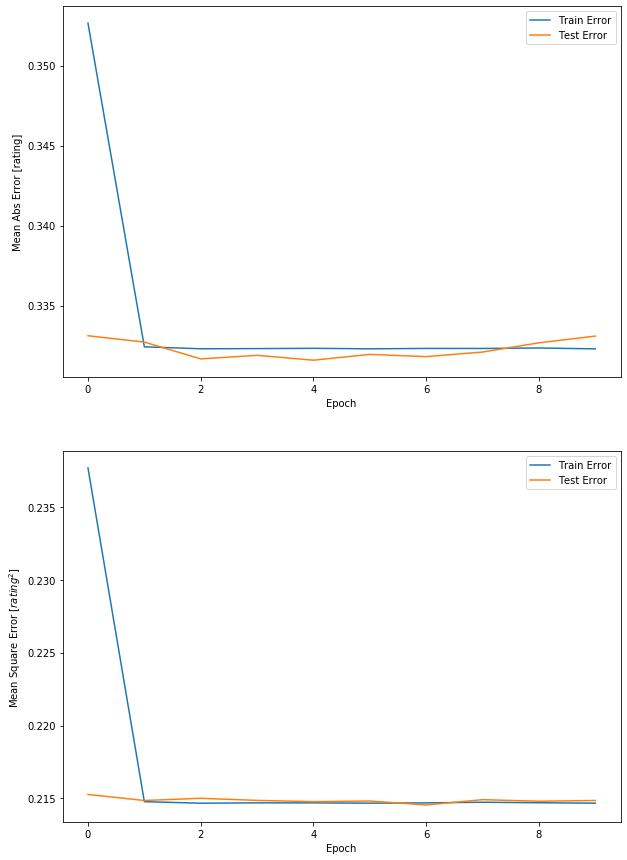

In [45]:
plot_history(hist3)

In [22]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) #initializer는 정규분포
        x = Reshape((self.n_factors,))(x)
        return 
    

## dropout 

In [32]:
from keras.layers import Concatenate, Dense, Dropout

#output에 dropout을 추가한 버전
##특히 dense layer를 2개 추가하였으며, 각각의 activation은 relu와 sigmoid이다. 가장 복잡한 버전

def RecommenderV3(n_users, n_movies, n_factors, min_rating, max_rating):
   
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer)
    
    #output: x, 연산과정
    x = Concatenate()([u, b])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    #완성되는 model
    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt)

    return model

In [33]:
re3model = RecommenderV3(n_users, n_beers, n_factors, min_rating, max_rating)
re3model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        8246750     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        15477100    input_10[0][0]                   
____________________________________________________________________________________________

In [34]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = re3model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 


Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 1752s 241us/step - loss: 0.2388 - mae: 0.3542 - mse: 0.2388 - val_loss: 0.1884 - val_mae: 0.3069 - val_mse: 0.1884
Epoch 2/10
7258502/7258502 [==============================] - 1689s 233us/step - loss: 0.2064 - mae: 0.3244 - mse: 0.2064 - val_loss: 0.1833 - val_mae: 0.3023 - val_mse: 0.1833
Epoch 3/10
7258502/7258502 [==============================] - 1735s 239us/step - loss: 0.1973 - mae: 0.3164 - mse: 0.1973 - val_loss: 0.1805 - val_mae: 0.2990 - val_mse: 0.1805
Epoch 5/10
7258502/7258502 [==============================] - 1697s 234us/step - loss: 0.1951 - mae: 0.3145 - mse: 0.1951 - val_loss: 0.1797 - val_mae: 0.2979 - val_mse: 0.1797
Epoch 6/10
7258502/7258502 [==============================] - 1701s 234us/step - loss: 0.1937 - mae: 0.3131 - mse: 0.1937 - val_loss: 0.1796 - val_mae: 0.2975 - val_mse: 0.1796
Epoch 7/10
7258502/7258502 [==============================] 

In [47]:
## fit model -- epoch 20번한 버전
seed = 7
np.random.seed(seed)
history_mf2 = re3model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/20
7258502/7258502 [==============================] - 1728s 238us/step - loss: 0.1889 - mae: 0.3091 - mse: 0.1889 - val_loss: 0.1788 - val_mae: 0.2969 - val_mse: 0.1788
Epoch 2/20
7258502/7258502 [==============================] - 1731s 238us/step - loss: 0.1884 - mae: 0.3086 - mse: 0.1884 - val_loss: 0.1788 - val_mae: 0.2972 - val_mse: 0.1788
Epoch 3/20
7258502/7258502 [==============================] - 1725s 238us/step - loss: 0.1878 - mae: 0.3081 - mse: 0.1878 - val_loss: 0.1792 - val_mae: 0.2975 - val_mse: 0.1792
Epoch 4/20
7258502/7258502 [==============================] - 1791s 247us/step - loss: 0.1874 - mae: 0.3077 - mse: 0.1874 - val_loss: 0.1788 - val_mae: 0.2972 - val_mse: 0.1788
Epoch 5/20
7258502/7258502 [==============================] - 1736s 239us/step - loss: 0.1870 - mae: 0.3074 - mse: 0.1870 - val_loss: 0.1790 - val_mae: 0.2963 - val_mse: 0.1790
Epoch 6/20
7258502/7258502 [==============================] -

In [35]:
## show loss & mae & mse at each epoch
hist4 = pd.DataFrame(history_mf.history)
hist4['epoch'] = history_mf.epoch
hist4

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.188354,0.306945,0.188354,0.238753,0.354244,0.238753,0
1,0.183275,0.302295,0.183275,0.206377,0.324425,0.206377,1
2,0.181723,0.300530,0.181722,0.200812,0.319459,0.200812,2
3,0.180534,0.299035,0.180534,0.197276,0.316408,0.197276,3
4,0.179712,0.297865,0.179712,0.195143,0.314529,0.195143,4
5,0.179569,0.297518,0.179569,0.193654,0.313132,0.193654,5
6,0.179185,0.296808,0.179185,0.192145,0.311875,0.192144,6
7,0.179615,0.297568,0.179615,0.191146,0.310975,0.191146,7
8,0.179329,0.297987,0.179329,0.190309,0.310207,0.190309,8
9,0.178334,0.296594,0.178334,0.189515,0.309577,0.189515,9


In [48]:
## show loss & mae & mse at each epoch --epoch 20번 버전
hist5 = pd.DataFrame(history_mf2.history)
hist5['epoch'] = history_mf2.epoch
hist5

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.178792,0.296857,0.178792,0.188913,0.309057,0.188913,0
1,0.178824,0.297179,0.178823,0.188447,0.308647,0.188447,1
2,0.179233,0.297506,0.179233,0.187787,0.308076,0.187787,2
3,0.178780,0.297214,0.178780,0.187363,0.307678,0.187364,3
4,0.178986,0.296349,0.178986,0.186964,0.307374,0.186964,4
5,0.178913,0.296599,0.178913,0.186824,0.307141,0.186824,5
6,0.178215,0.295457,0.178215,0.186342,0.306709,0.186343,6
7,0.179591,0.296822,0.179590,0.186086,0.306524,0.186087,7
8,0.178418,0.296053,0.178417,0.185803,0.306301,0.185803,8
9,0.178311,0.296074,0.178311,0.185561,0.306074,0.185561,9


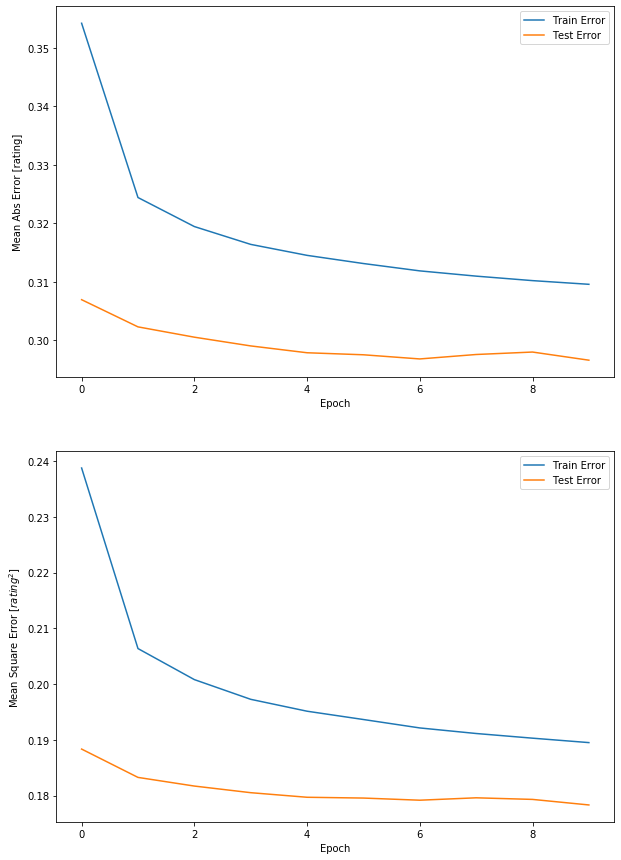

In [44]:
plot_history(hist4)

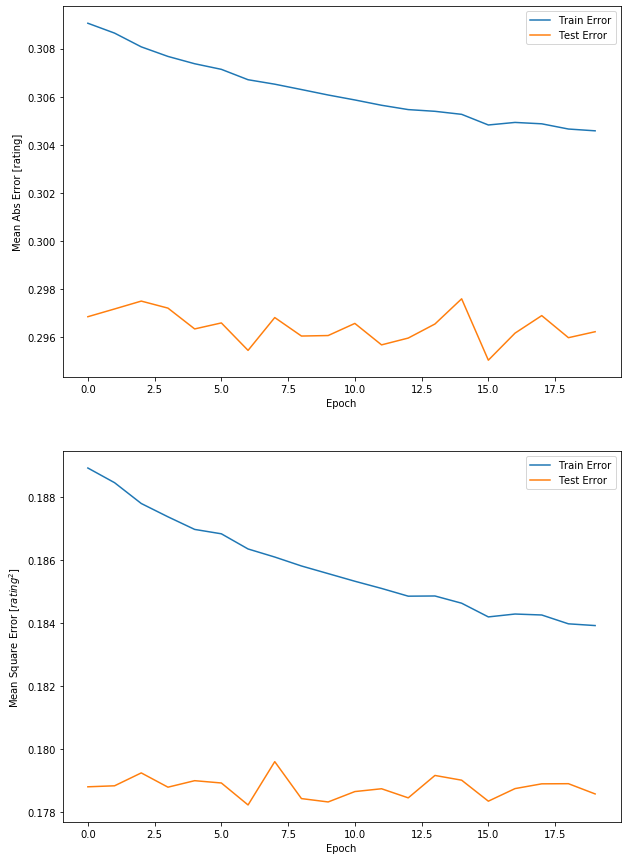

In [50]:
plot_history(hist5)

In [36]:
#모델 평가하기; model.evaluate()
loss_and_metrics = re3model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 6s 3us/step
## evaluation loss and_metrics ##
[0.1783340476847047, 0.296593576669693, 0.1783340573310852]


In [51]:
#20번 버전 
#모델 평가하기; model.evaluate()
loss_and_metrics = re3model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 9s 5us/step
## evaluation loss and_metrics ##
[0.1785651017746869, 0.2962329685688019, 0.17856498062610626]


In [52]:
## get weights of the beers embedding matrix
beer_embedding_weights = re3model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [53]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [41]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.78686005, 0.11961538, 0.02359777], dtype=float32)

In [54]:
#20번 버전
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.7642738 , 0.14852946, 0.03598557], dtype=float32)

In [55]:
#여기서부턴 전부 20번 버전
from operator import itemgetter

## extract first PCA
pca0 = beer_pca.components_[0]

## get the value (pca0, beer title)
beer_comp0 = [(f, beers_dict[i]) for f,i in zip(pca0, list(beers_dict.keys()))]

In [56]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.013569722, 'Cream Ale'),
 (0.012582743, 'Sunday Driving'),
 (0.010959065, 'Dirty Bastard - Bourbon-Soaked Apricots And Ginger'),
 (0.010454713, 'Rolo Tony Brown Town'),
 (0.01038827, 'Carrabassett Pale Ale'),
 (0.010299142, "Weekend At Brett's Barrel Aged"),
 (0.010174001, 'Bean Me Up Espresso Milk Stout'),
 (0.010076623, 'Nocturnality'),
 (0.010031739, 'Ahhh You Again'),
 (0.009913673, 'Morning Juice 6')]

In [57]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0, key = itemgetter(0))[:10]

[(-0.014319813, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (-0.011460765, 'City Steam American Wheat'),
 (-0.0113334935, 'Double Stuffed Marshmallow and Chocolate Cranium'),
 (-0.011072019, 'Bare Tree Weiss Wine Vintage 2003'),
 (-0.01096, "Monk's Phunk"),
 (-0.010704503, 'Jolly Golden Ale'),
 (-0.010558221, 'Saison Garni'),
 (-0.010292491, 'Peach Wheat'),
 (-0.010199628, 'Mad3 Folks Bier'),
 (-0.010035179, 'Buckeye Beer')]

### 제대로 모델이 만들어졌을까? 한번 추천해보자.

In [59]:
#20번 - 예측
re3model.predict([[5277],[43752]])[0][0]

3.740604

In [60]:
#유저가 평가하지 않은 beer목록을 반환해 주는 함수 : get_unbeer_keras

def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    
    total_beers = df['beer'].unique().tolist() #모든 beer
    
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    
    print('이미 평가한 beer 수: ', len(beers), '안 평가한 beer 수: ' , len(unbeers), '전체 beer 수: ', len(total_beers))
    
    return unbeers

In [61]:
#userid는 항상 숫자로!!
unbeers = get_unbeer_keras(df2, 5227) #해당 유저아이디의 평가안한 unbeers(list)가 반환 

이미 평가한 beer 수:  1 안 평가한 beer 수:  309541 전체 beer 수:  309542


In [68]:
def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    total_beers = df['beer'].unique().tolist() #모든 beer
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    return unbeers

def recomm_beer_by_keras(userid, model, top_n):
    unbeers = get_unbeer_keras(df,userid)
    predict =[v[0][0] for v in  [model.predict([[userid],[beer]]) for beer in unbeers]]
    ndf= pd.DataFrame({'beer':unbeers,'rating':predict})
    final = ndf.sort_values(by='rating', ascending=False)[:top_n]
    return final


In [69]:
%%time
userid = int(input('ID를 입력하세요.당신이 선호할 만한 맥주를 추천해드립니다. '))
topn= int(input('몇 가지의 맥주를 추천해 드릴까요? '))

unbeers = get_unbeer_keras(df2, userid)
recomm_beer_by_keras(userid, re2model, topn)

ID를 입력하세요.당신이 선호할 만한 맥주를 추천해드립니다. 5227
몇 가지의 맥주를 추천해 드릴까요? 10
Wall time: 6min 37s


,beer,rating
186812,68022,4.947903
253136,101353,4.922272
104965,129086,4.910248
204533,171119,4.910101
86573,230155,4.881294
161204,141547,4.880967
85624,86880,4.865480
79531,102972,4.861054
274601,217720,4.861049
292087,147772,4.859876
